In [240]:
from GraphModels.model import *
from GraphModels.solvers import *
from GraphModels.metrics import *
import networkx as nx
import matplotlib.pyplot as plt
import random
from experiments import *

from scipy.optimize import curve_fit

%autoreload 2

In [246]:
def f(x, a, b, c):
    return a * np.power(x, b) + c

params = curve_fit(f, np.arange(0.1, 1, 0.1), [0.94, 0.87, 0.85, 0.77, 0.74, 0.68, 0.64, 0.55, 0.4])[0]

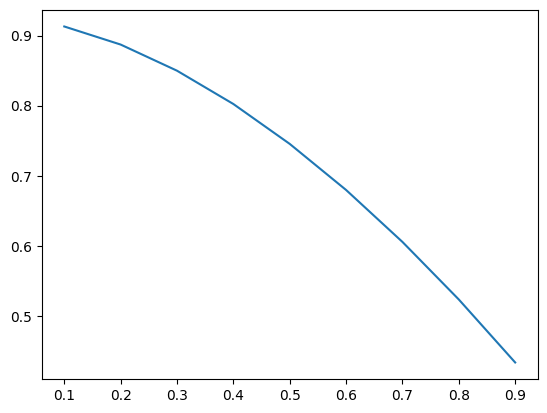

In [247]:
plt.plot(np.arange(0.1, 1, 0.1), f(np.arange(0.1, 1, 0.1), *params))

In [234]:
familywise_MHT_experiments(CholCorrModel, 5, 0.94, 40, 20, 100, metrics=[TP, TN, FP, FN])

array([[0.404 , 0.307 , 0.307 , 0.31  , 0.266 ],
       [8.966 , 9.4045, 9.4025, 9.3795, 9.4295],
       [0.484 , 0.0455, 0.0475, 0.0705, 0.0205],
       [0.146 , 0.243 , 0.243 , 0.24  , 0.284 ]])